# 导入必要包

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
import matplotlib.pyplot as plt
from torch.utils.data import  Dataset,random_split,DataLoader
import pandas as pd
from sklearn.metrics import mean_squared_error as mse_fn, mean_absolute_error as mae_fn

# 一些超参数们

In [43]:
batch_size = 64

epoch = 2000
window_size = 6

# 数据集的导入

In [44]:
# 导入相关库
import random
from torch.utils.data import Dataset

def data_process(train,test,windows_size):
    train = train.reshape(train.shape[0])
    test = test.reshape(test.shape[0])
  
    train_tensor = torch.from_numpy(train)
    train_windows_split=train_tensor.unfold(0,windows_size,1)
    train_set = train_windows_split.numpy()

    test_tensor = torch.from_numpy(test)
    test_windows_split=test_tensor.unfold(0,windows_size,1)
    test_set = test_windows_split.numpy()

    #将训练集短序列打乱
    train_temp1 = train_set.tolist()
    random.shuffle(train_temp1)
    train_temp2 = np.array(train_temp1)

    test_temp1 = test_set.tolist()
    random.shuffle(test_temp1)
    test_temp2 = np.array(test_temp1)

    # 将短序列划分为 featrue label
    train_feature_array =  train_temp2[:,:windows_size-1]
    train_label_array = train_temp2[:,windows_size-1:]


    test_feature_array = test_temp2[:,:windows_size-1]
    test_label_array = test_temp2[:,windows_size-1:]
   
    # 将nparray 转为 tensor
    train_feature_tensor = torch.from_numpy(train_feature_array)
    train_label = torch.from_numpy(train_label_array)
    test_feature_tensor = torch.from_numpy(test_feature_array)
    test_label = torch.from_numpy(test_label_array)
    # 扩展数据维度，符合CNN输入
    print(train_feature_tensor.shape[0])
    train_feature = train_feature_tensor.reshape(train_feature_tensor.shape[0],1,train_feature_tensor.shape[1])
    test_feature = test_feature_tensor.reshape(test_feature_tensor.shape[0],1,test_feature_tensor.shape[1])

    return train_feature,train_label,test_feature,test_label
# 定义自定义数据集类 my_Dataset
class my_Dataset(Dataset):
    def __init__(self, features, labels):
        self.X = features.to(torch.float32)
        self.y = labels.to(torch.float32)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.X.shape[0]

# 定义 alcohol_Dataset 类
class alcohol_Dataset:
    def __init__(self):
        # 读取 CSV 文件
        self.raw_data = pd.read_csv(r'E:\PythonCode\DeepLearning\Time_Series\data\experment_03\alcohol.csv')
        # 将包含日期的列转换为 datetime 类型
        self.raw_data['DATE'] = pd.to_datetime(self.raw_data['DATE'])
        # 获取时间序列和数据
        self.time =  self.raw_data['DATE']
        self.data  = self.raw_data['S4248SM144NCEN']
        # 设置索引
        self.raw_data.set_index('DATE',inplace=True)
        # 计算最小值和最大值
        self.min = self.raw_data.min()[0]
        self.max = self.raw_data.max()[0]
        # 对数据进行归一化处理
        self.data =  self.raw_data

    # 反归一化操作
    def denormalize(self, x):
       
        return x * (self.max - self.min) + self.min

    # 构建训练集和测试集
    def construct_set(self, window_size=6, label=0,split=0.6):
        train_x = []
        train_y = []
        test_x = []
        test_y = []
        len_train = int(self.data.shape[0] * split)
        train_seqs = self.data[:len_train]
        test_seqs=self.data[len_train:]
        train_feature,train_label,test_feature,test_label=data_process(train_seqs.values,test_seqs.values,window_size)
        train_set = my_Dataset(train_feature, train_label)
        test_set = my_Dataset(test_feature, test_label)
        return train_set, test_set    

# 创建 alcohol_Dataset 实例并构建数据集
dataset  = alcohol_Dataset()
train_set, test_set = dataset.construct_set(window_size=window_size)
# 创建dataloader
train_loader = DataLoader(train_set,batch_size=batch_size,shuffle=True,num_workers=0,drop_last=True)
test_loader =  DataLoader(test_set,batch_size=batch_size,shuffle=True,num_workers=0,drop_last=True)

190


# 搭建CNN模型

In [45]:
class ConvModel(nn.Module):
   def __init__(self):
       super(ConvModel,self).__init__()
       self.conv1 = nn.Sequential(
           nn.Conv1d(in_channels=1,out_channels=32,kernel_size=4,stride=1,padding=1),
           nn.ReLU(inplace=True)
       )
       self.conv2 = nn.Sequential(
           nn.Conv1d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1),
           nn.ReLU(inplace=True)
       )
       
       self.fc1=  nn.Linear(64,32)
       self.fc2 = nn.Linear(32,1)
   def forward(self,x):
    
       out =  self.conv1(x)
       out = F.avg_pool1d(out,2) # 平均池化
       out = self.conv2(out)
       out = F.avg_pool1d(out,2) # 平均池化层
       out = out.squeeze()
       out = self.fc1(out)
       out = self.fc2(out)
       return out

# 编写评估代码

In [46]:
def eval(y, pred):
    # y = y.cpu().numpy()
    # pred = pred.cpu().numpy()
    mse = mse_fn(y, pred)
    rmse = math.sqrt(mse)
    mae = mae_fn(y, pred)
    return [rmse, mae]

# 训练模型

In [47]:
# 训练模型
lr  = 0.00001
net = ConvModel()
opt = torch.optim.Adam(net.parameters(),lr=lr)
loss  = nn.L1Loss()

train_loss = []
test_loss = []
for epoch_num in range(epoch):
    train_list = []
    test_list = []
    rmse_list = []
    mae_list = []
    for x,y in train_loader:
      
        y_hat = net(x)
        l = loss(y_hat,y)
        train_list.append(l.item())
    
        l.backward()
        opt.zero_grad()
        opt.step()
          
       
    for x,y in test_loader:
        y_hat = net(x)
        l = loss(y_hat,y)
        # print(y)
        test_list.append(l.item())
      
        # y = dataset.denormalize(y.view(-1).detach().numpy())
        # y_hat = dataset.denormalize(y_hat.view(-1).detach().numpy())
        # rmse_a, mae_a =eval(y, y_hat)
        # rmse_list.append(rmse_a)
        # mae_list.append(mae_a)
    test_loss.append(np.mean(test_list))
    train_loss.append(np.mean(train_list))
    print("epoch:",epoch_num+1,
          "train_loss:",np.mean(test_list),
          "test_loss:", np.mean(train_list),
          "mse:",np.mean(rmse_list),
          "mae",np.mean(mae_list)
          )

epoch: 1 train_loss: 11603.3486328125 test_loss: 6253.000244140625 mse: nan mae nan
epoch: 2 train_loss: 11077.67578125 test_loss: 6138.218505859375 mse: nan mae nan
epoch: 3 train_loss: 11131.26171875 test_loss: 6167.8310546875 mse: nan mae nan
epoch: 4 train_loss: 11316.4091796875 test_loss: 6190.373291015625 mse: nan mae nan
epoch: 5 train_loss: 11369.8232421875 test_loss: 6216.629638671875 mse: nan mae nan
epoch: 6 train_loss: 11095.240234375 test_loss: 6229.385009765625 mse: nan mae nan
epoch: 7 train_loss: 10835.001953125 test_loss: 6249.50244140625 mse: nan mae nan


c:\ProgramData\anaconda3\envs\DeepLearning\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\ProgramData\anaconda3\envs\DeepLearning\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


epoch: 8 train_loss: 11214.263671875 test_loss: 6272.368408203125 mse: nan mae nan
epoch: 9 train_loss: 11478.908203125 test_loss: 6155.084228515625 mse: nan mae nan
epoch: 10 train_loss: 11086.001953125 test_loss: 6150.480224609375 mse: nan mae nan
epoch: 11 train_loss: 10865.724609375 test_loss: 6117.732666015625 mse: nan mae nan
epoch: 12 train_loss: 11020.1767578125 test_loss: 6302.477294921875 mse: nan mae nan


epoch: 13 train_loss: 11333.638671875 test_loss: 6260.541748046875 mse: nan mae nan
epoch: 14 train_loss: 11369.7822265625 test_loss: 6234.64599609375 mse: nan mae nan
epoch: 15 train_loss: 11532.8857421875 test_loss: 6288.43701171875 mse: nan mae nan
epoch: 16 train_loss: 11275.748046875 test_loss: 6407.154296875 mse: nan mae nan
epoch: 17 train_loss: 11127.5966796875 test_loss: 6338.42333984375 mse: nan mae nan
epoch: 18 train_loss: 10999.1357421875 test_loss: 6365.65283203125 mse: nan mae nan
epoch: 19 train_loss: 11310.669921875 test_loss: 6108.350341796875 mse: nan mae nan
epoch: 20 train_loss: 10887.8359375 test_loss: 6114.90966796875 mse: nan mae nan
epoch: 21 train_loss: 10752.8046875 test_loss: 6161.359375 mse: nan mae nan
epoch: 22 train_loss: 11016.1787109375 test_loss: 6199.8896484375 mse: nan mae nan
epoch: 23 train_loss: 11206.705078125 test_loss: 6319.545166015625 mse: nan mae nan
epoch: 24 train_loss: 11183.5234375 test_loss: 6183.61572265625 mse: nan mae nan
epoch: 25 

KeyboardInterrupt: 

# 预测

torch.Size([125, 1, 5])
tensor([[11274.],
        [11224.],
        [10839.],
        [ 7266.],
        [11344.],
        [13310.],
        [10828.],
        [ 6901.],
        [11905.],
        [10328.],
        [12218.],
        [ 8641.],
        [ 9413.],
        [12700.],
        [11416.],
        [10085.],
        [ 9424.],
        [10055.],
        [10843.],
        [13914.],
        [11107.],
        [12022.],
        [10965.],
        [11506.],
        [14265.],
        [ 9059.],
        [11462.],
        [12238.],
        [ 9709.],
        [13545.],
        [14138.],
        [ 9272.],
        [12640.],
        [11792.],
        [10470.],
        [ 8888.],
        [ 9043.],
        [ 9948.],
        [11186.],
        [10718.],
        [14257.],
        [11922.],
        [13016.],
        [10953.],
        [12481.],
        [ 9866.],
        [ 8648.],
        [10452.],
        [12396.],
        [10552.],
        [ 9832.],
        [10110.],
        [ 7578.],
        [11138.],
    

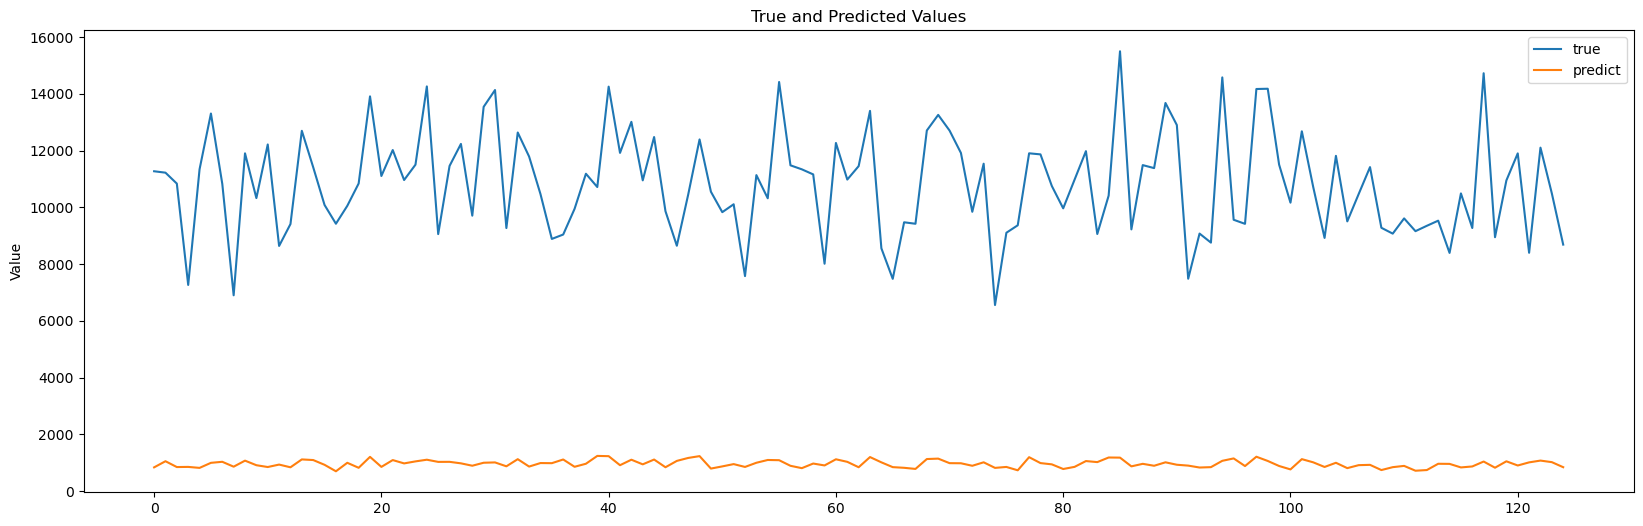

In [ ]:
print(test_set[:][0].shape)

print(test_set[:][1])
# 测试集真实序列
test_true = test_set[:][1]
# 测试集预测序列

test_predict = net(test_set[:][0]).squeeze().tolist()

plt.figure(figsize=(20, 6))
plt.plot(test_true, label='true')
plt.plot(test_predict, label='predict')
plt.ylabel('Value')
plt.title('True and Predicted Values')
plt.legend()
plt.show()